# Testing pybiblionet

This notebook demonstrates the installation and basic usage of the pybiblionet package.  

## Steps
1. Install the library from PyPI.
2. Import the library and gather articles.
3. Show graphs generated by a query.
4. Perform network analysis.



#1. Install the library from PyPI.


In [ ]:
!pip install pybiblionet

# 2. Import the library and gather articles.


In this section, we need to specify the query parameters for retrieving data.  
The process involves three main steps:

1. **Query generation**  
   A query string is created using a generator that follows a *lite regex–like approach*.

2. **User identification (email)**  
   You should provide your email address.  
   This is required by OpenAlex to identify who is making the request and to help monitor rate limits.  
   ⚠️ *No registration is required — just an email string.*

3. **Time interval**  
   Define the publication date range of interest by setting the start and (optionally) the end date.


In [ ]:
import json
from pathlib import Path

from pybiblionet.openalex.core import string_generator_from_lite_regex, retrieve_articles, create_citation_graph, \
    create_coauthorship_graph, export_articles_to_csv, export_authors_to_csv, export_venues_to_csv, \
    export_institutions_to_csv, export_articles_to_scopus

# This script retrieves academic articles from OpenAlex related to the concept of "15-minute city"
# using a regex-based query. It exports the retrieved articles and their authors to CSV files,
# then generates and saves two graph representations: a citation graph and a co-authorship graph.
# Finally, it prints the number of nodes and edges in each graph to give an overview of their structure.
if __name__ == "__main__" :


    queries = string_generator_from_lite_regex("(15)( )(minute|min)( )(city)")

    mail = "youremail@example.com"
    from_publication_date = "2024-09-01"
    to_publication_date = None
    json_file_path = retrieve_articles(queries, mail, from_publication_date, to_publication_date)

    export_institutions_to_csv(json_file_path,
                           fields_to_export=None,
                           export_path="15minute_institutions.csv"
                           )

    export_venues_to_csv(json_file_path,
                           fields_to_export=None,
                           export_path="15minute_venues.csv"
                           )

    export_articles_to_csv(json_file_path,
                           fields_to_export=None,
                           export_path="15minute_articles.csv"
                           )
    export_authors_to_csv(json_file_path,
                           fields_to_export=None,#["author id", "author orcid", "author display_name"],
                           export_path="15minute_authors.csv"
                           )

    articles = json.load(open(json_file_path))
    G_citation=create_citation_graph(articles,"15minute_citation_graph.GML",base_set=True)

    print(G_citation.number_of_nodes(),G_citation.number_of_edges())

    G_coauthorship=create_coauthorship_graph(articles,"15minute_coauthorship_graph.GML",base_set=True)

    print(G_coauthorship.number_of_nodes(),G_coauthorship.number_of_edges())



# 3. Show graphs generated by a query.

In this section, based on the data previously collected, we demonstrate the method calls that enable the visualization of the available graphs.  

It is important to specify the correct path for the output of the query results.  
Note that the file name is automatically generated as a **hash of the search query**.  
Therefore, for each different query, a new output file with a different name will be created.



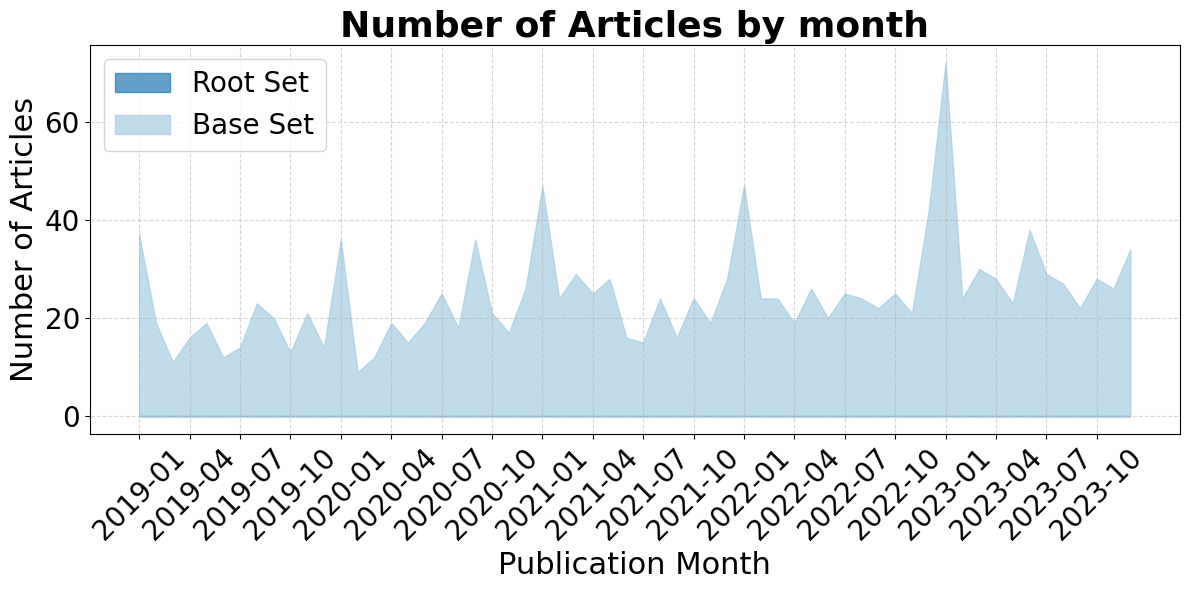

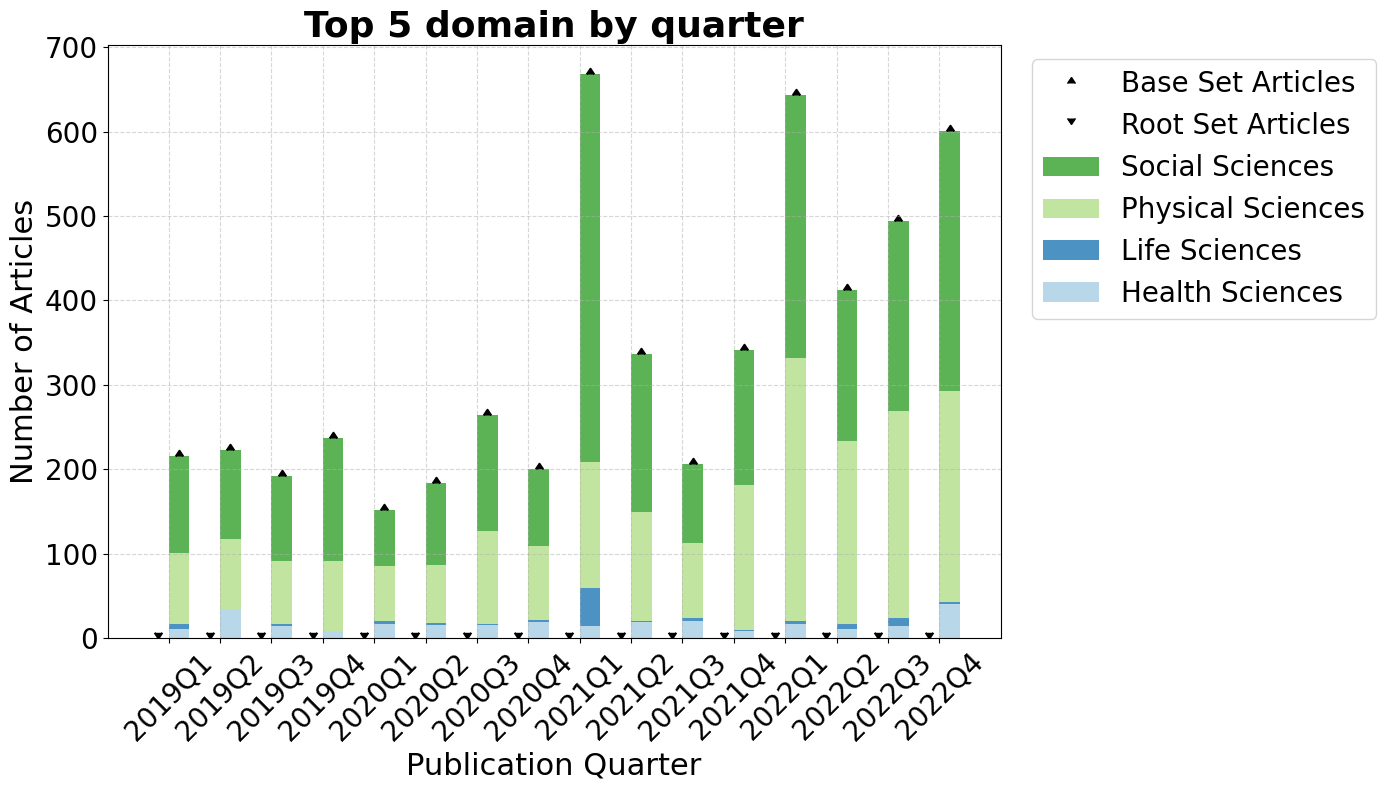

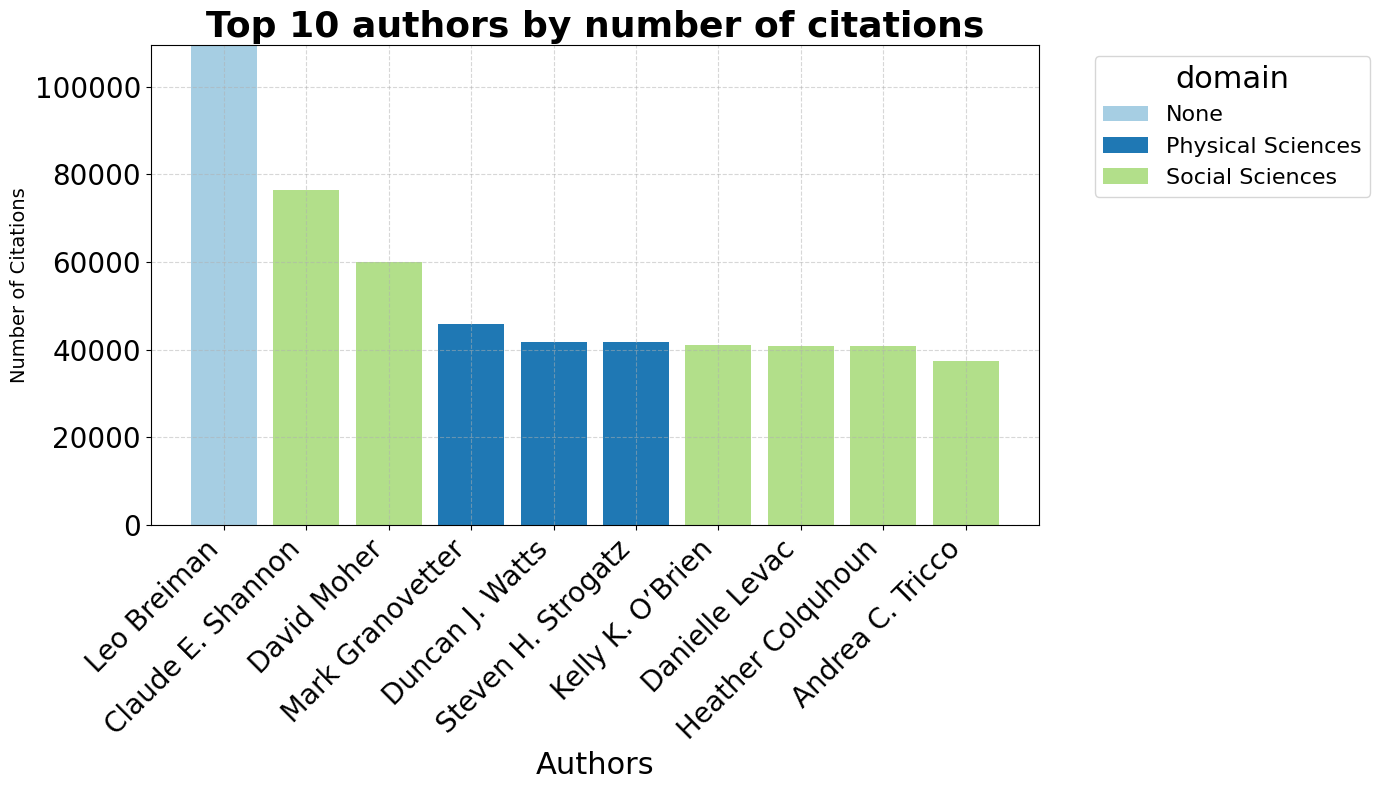

100%|██████████| 180/180 [01:55<00:00,  1.56it/s]


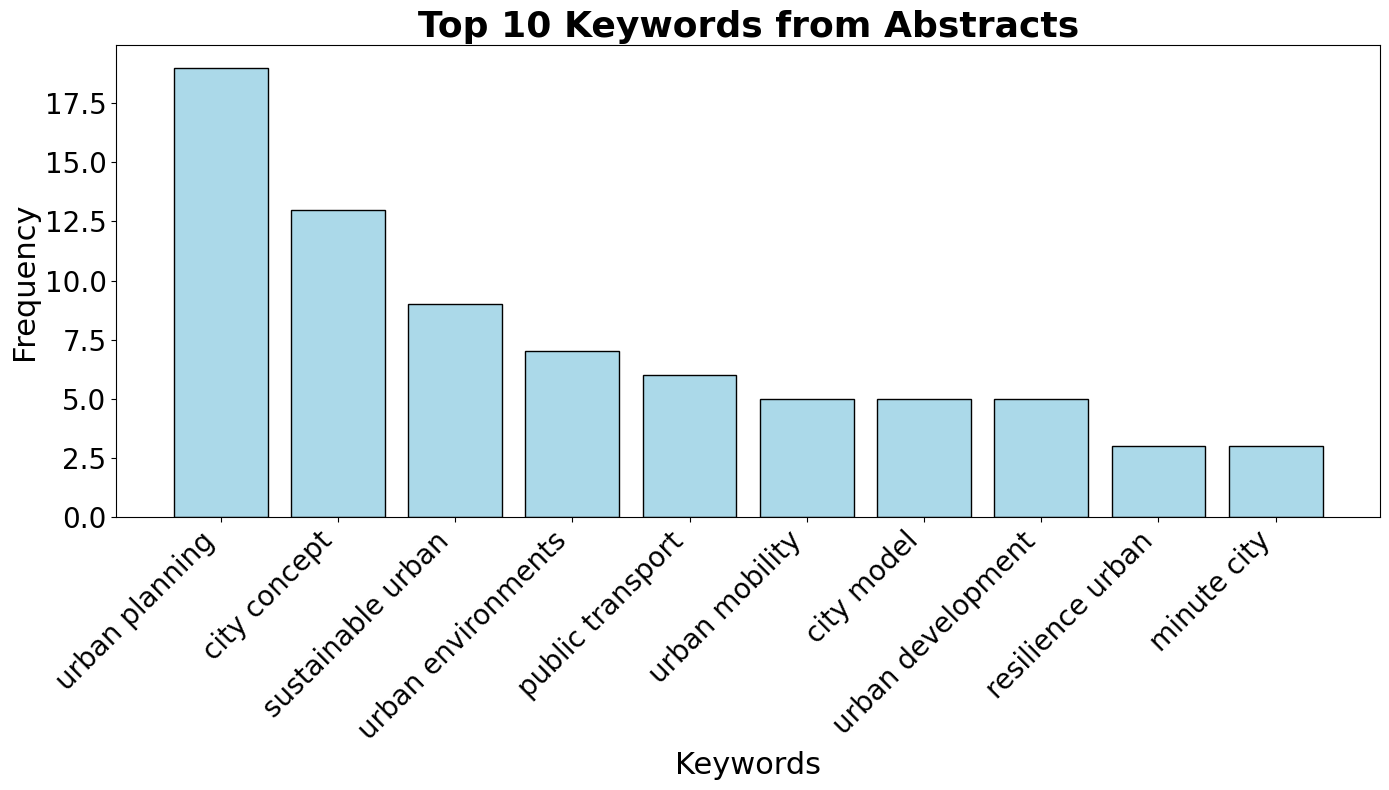

100%|██████████| 180/180 [18:39<00:00,  6.22s/it]


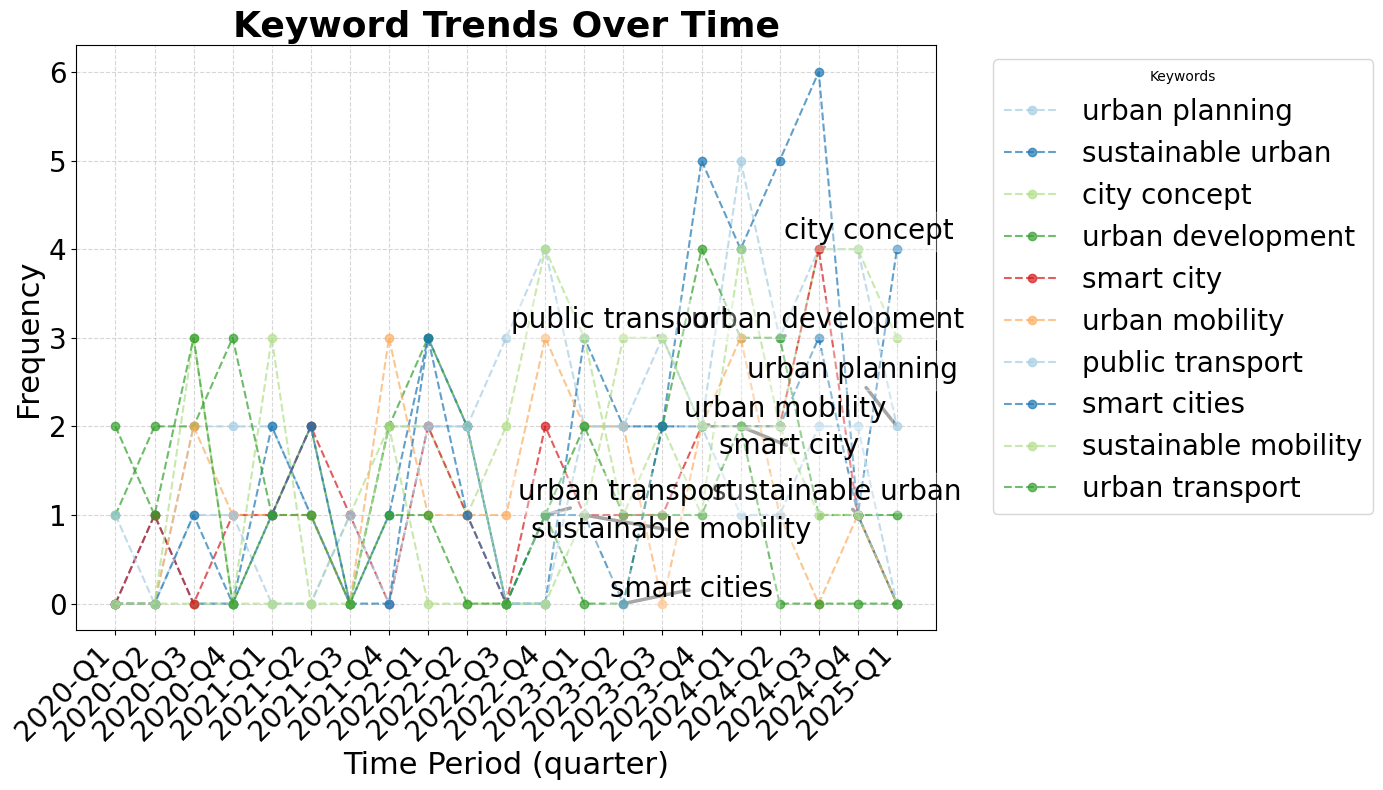

In [6]:
from pybiblionet.bibliometric_analysis.charts import plot_topic_trends, plot_article_trends, \
    plot_top_authors, plot_top_keywords_from_abstracts, plot_keyword_trends
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import json

# This script performs various bibliometric analyses on a set of academic articles stored in a JSON file (recovered using test_openalex.py).
# It generates several visualizations:
# 1. Article publication trends over time (by month, quarter, or year).
# 2. Topic trends over time, highlighting core and periphery topics.
# 3. Top authors based on citation count, focusing on the most cited authors.
# 4. Top keywords extracted from article abstracts.
# 5. Keyword trends over time, showing the frequency of keywords and their evolution.
# The script uses `matplotlib` for plotting and supports customization for the time intervals, number of authors,
# and other aspects of the analysis.
if __name__ == "__main__" :


    json_file_path= "query_results/query_result_1ea020320b230de5a973a39682eaa53dce89a9bb026b441a5f825232.json"
    articles = json.load(open(json_file_path))



    plot_article_trends(articles,
                        date_from=datetime(2019, 1, 1),
                        interval="month",  # Change to "month" or "quarter" or "year" as needed
                        date_to=datetime(2023, 12, 31),
                        num_ticks=20)
    plot_topic_trends(
        articles,
        top_n_colors= ["#a6cee3","#1f78b4","#b2df8a","#33a02c","#d7191c"],
        show_root_set=True,
        show_base_set=True,
        interval="quarter", # Change to "quarter" or "year"
        date_from=datetime(2019, 1, 1),
        date_to=datetime(2022, 12, 31),
        top_n=5,
        )
    plot_top_authors(
        articles,
        date_from=datetime(2019, 1, 1),
        date_to=datetime(2025, 12, 31),
        num_authors=10,
        by_citations=True,
        show_base_set=True,
        n_colors=["#a6cee3","#1f78b4","#b2df8a","#33a02c","#d7191c","#fdae61"]
    )

    plot_top_keywords_from_abstracts(articles)


    plot_keyword_trends(
        articles=articles,
        date_from=datetime(2020, 1, 1),
        date_to=datetime(2025, 1, 1),
        show_root_set=True,
        show_base_set=True,
        top_n=10,
        ngram_range=(1, 2),
        interval="quarter",
        n_colors=["#a6cee3", "#1f78b4", "#b2df8a", "#33a02c", "#d7191c", "#fdae61"]
    )


# 4. Perform network analysis.


In this final code section, we demonstrate how to invoke the methods that analyze the network using **NetworkX** and display the available visualizations.  
As in the previous step, it is necessary to specify:  

- the **output file** of the query, and  
- the **path to the network in GML format**, which was generated in Step 1.

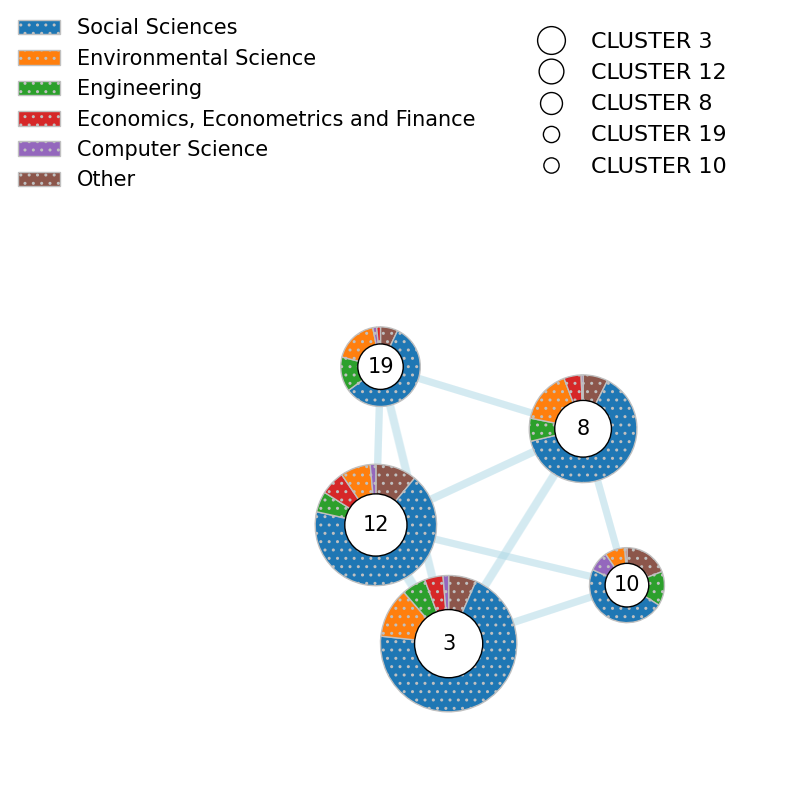

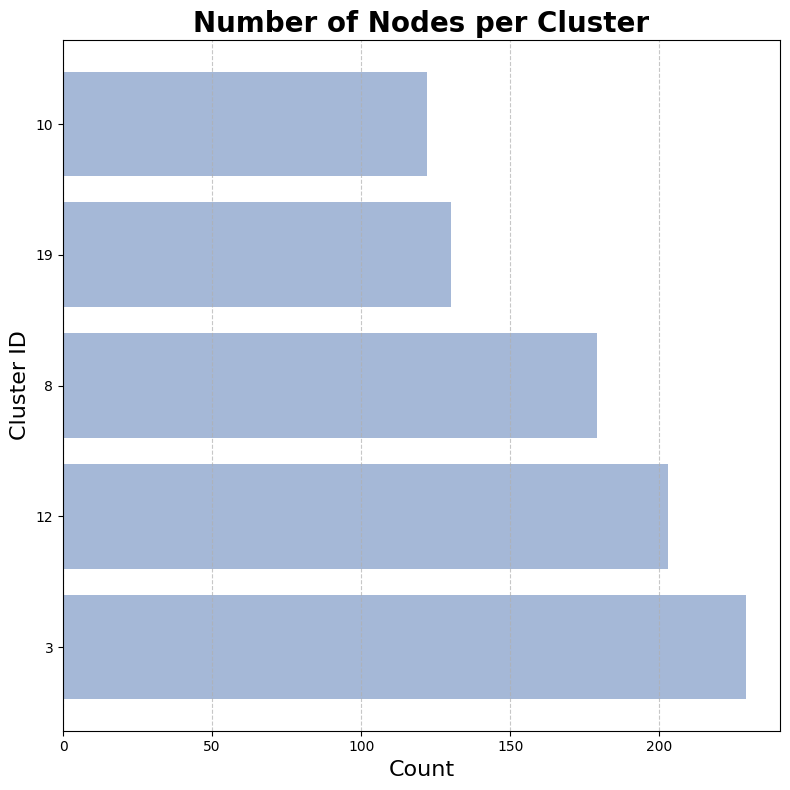

In [9]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from pybiblionet.bibliometric_analysis.core import extract_metrics_to_csv, cluster_graph, extract_clusters_to_csv
from pybiblionet.bibliometric_analysis.charts_network import show_clustered_graph, show_cluster_statistics,show_graph_statistics
from matplotlib import colors

# This script performs several operations on a citation graph of academic articles (recovered using test_openalex.py):
# 1. Loads a graph from a GML file using `networkx`.
# 2. Extracts a set of centrality and degree metrics from the graph (betweenness centrality, closeness centrality,
#    eigenvector centrality, page rank, in-degree, and out-degree), and saves them along with additional article fields
#    into a CSV file.
# 3. Applies the Louvain clustering algorithm to the graph to detect communities (clusters) of articles.
# 4. Saves the extracted cluster information (e.g., node IDs) to another CSV file.
# 5. Visualizes the clustered graph using `show_clustered_graph`, showing different clusters of articles.
# 6. Generates and displays a bar chart with statistics about the clusters, such as the number of nodes per cluster.
# This analysis allows for exploring the structure of the network of academic citations and understanding the distribution
# of various metrics and clusters within the data.

if __name__ == "__main__":

    # Read the graph

    json_file_path="query_results/query_result_1ea020320b230de5a973a39682eaa53dce89a9bb026b441a5f825232.json"
    network_file_name= "15minute_citation_graph.GML"

    G = nx.read_gml(network_file_name)
    print("Graph loaded.")
    print(G.number_of_nodes(), G.number_of_edges())

    # Extract and save metrics to CSV
    metrics = ["betweenness_centrality",
            "closeness_centrality",
            #"eigenvector_centrality",
            "page_rank",
            "in_degree",
            "out_degree"]
    fields = ["id", "title","cited_by_count","root_set","primary_topic display_name",
                            "primary_topic subfield display_name",
                            "primary_topic field display_name",
                            "primary_topic domain display_name"]
    csv_file_path = "metrics_and_fields_citation.csv"

    print("Extracting metrics...")
    extract_metrics_to_csv(G, metrics, fields, csv_file_path)
    #exit()
    #show_graph_statistics(G,csv_file_path)

    print("Metrics extracted and saved to CSV.")

    print("\nClustering the graph...")
    fields = ["id"]
    clustered_graph = cluster_graph(G, algorithm='louvain',)
    csv_file_path = "cluster_and_fields_citation.csv"
    extract_clusters_to_csv(clustered_graph, fields, csv_file_path)
    #exit()
    print("Clusters extracted and saved to CSV.")
    # Visualize clusters
    print("Visualizing clusters...")
    show_clustered_graph(clustered_graph, image_size=(800, 800),
                         n_clusters=5,
                         topics_level="field",
                         #min_node_radius=3,
                         #max_node_radius=5,
                         #max_pie_radius=5,
                         #min_pie_radius=3,
                         #size_node_font=12
                         )

    show_cluster_statistics(csv_file_path, image_size=(800, 800),
                 n_clusters=5)